In [17]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

Train Model

In [33]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale= 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)


train_generator = train_datagen.flow_from_directory(
    '../dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '../dataset/validation',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
)

test_generator = test_datagen.flow_from_directory(
    '../dataset/test',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)



Found 2623 images belonging to 3 classes.
Found 561 images belonging to 3 classes.
Found 565 images belonging to 3 classes.


In [34]:
train_dir = '../dataset/train'

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {count} images")

nickels: 849 images
pennies: 899 images
quarters: 875 images


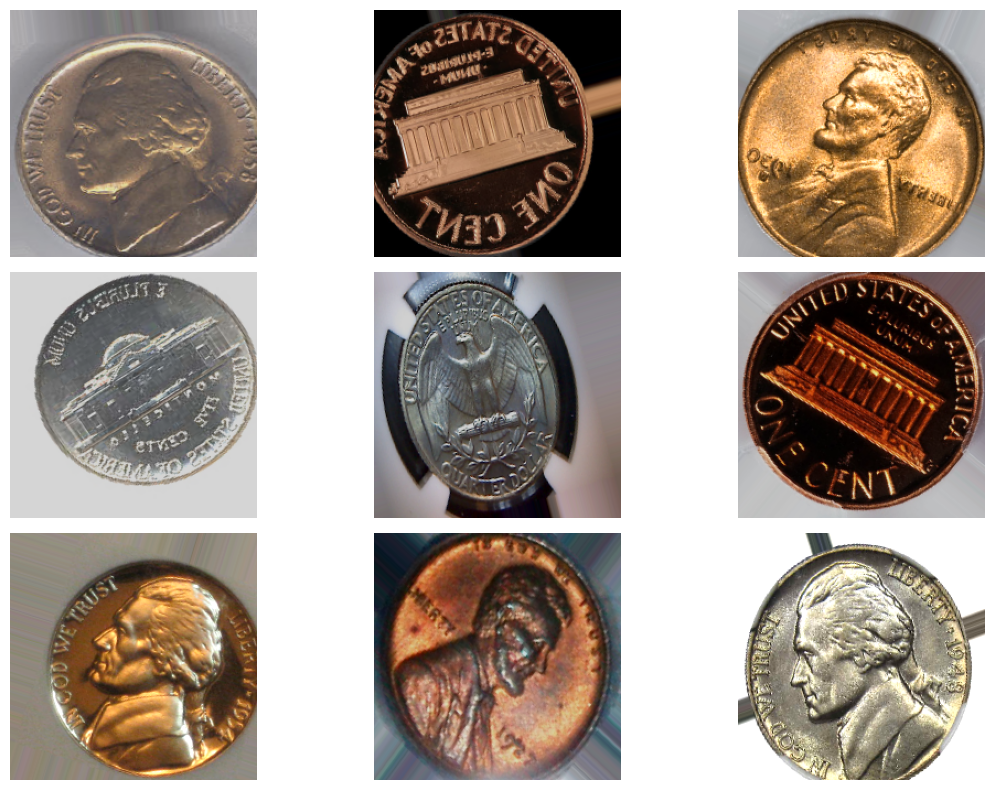

In [20]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 8))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [43]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 3)                

In [44]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50)

Epoch 1/50
82/82 [==============================] - 77s 846ms/step - loss: 1.2777 - accuracy: 0.3157 - val_loss: 1.1035 - val_accuracy: 0.3244
Epoch 2/50
 9/82 [==>...........................] - ETA: 54s - loss: 1.2284 - accuracy: 0.3403

KeyboardInterrupt: 

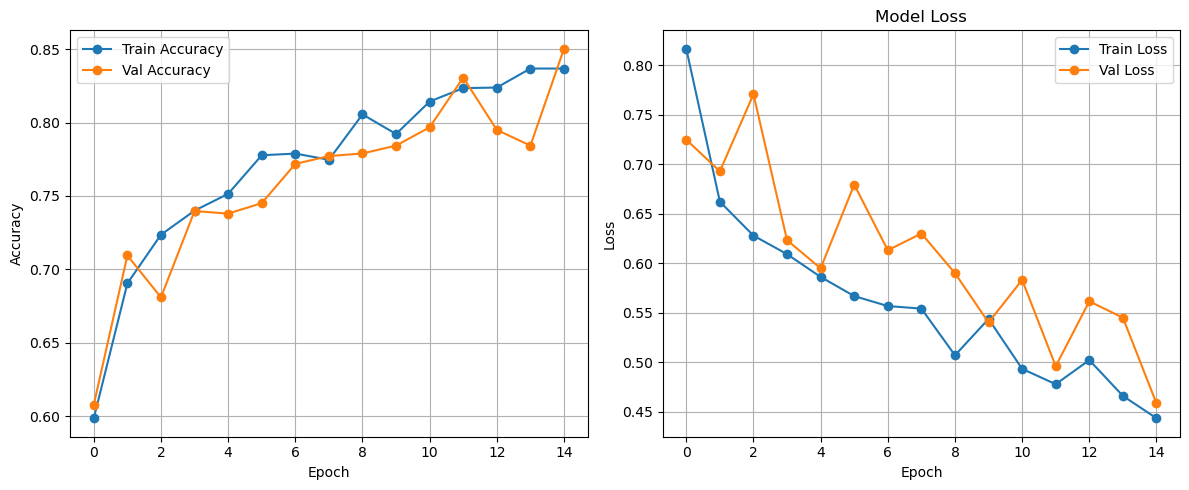

In [7]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label= 'Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label= 'Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 [==============================] - 4s 230ms/step - loss: 0.3876 - accuracy: 0.8549
Test Loss: 0.3876069188117981
Test Accuracy: 0.8548672795295715


In [9]:
# Get the true labels from the test generator
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

18/18 [==============================] - 4s 231ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       183
           1       0.88      0.94      0.91       194
           2       0.89      0.76      0.82       188

    accuracy                           0.85       565
   macro avg       0.86      0.85      0.85       565
weighted avg       0.86      0.85      0.85       565

Confusion Matrix:
[[158  13  12]
 [  7 182   5]
 [ 34  11 143]]


In [10]:
model.save('../models/my_model.h5')